In [1]:
import findspark

In [ ]:
spark = findspark.init('/home/danial/spark-3.4.0-bin-hadoop3')

In [ ]:
# for my spark on windows

# no need for this 
#spark = findspark.init('C:\Program Files\spark-3.4.0-bin-hadoop3')

In [1]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import (BinaryClassificationEvaluator,
                                    MulticlassClassificationEvaluator)
from pyspark.ml.feature import (StringIndexer, VectorAssembler,
                               OneHotEncoder)
from pyspark.sql.session import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, sum
from pyspark.ml.classification import (RandomForestClassifier,
                                       GBTClassifier,
                                       DecisionTreeClassifier)
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import pandas as pd


In [2]:
spark = SparkSession.builder.config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.42.0.0').getOrCreate()

In [ ]:
df_spark = spark.read.format('jdbc').options(driver='org.sqlite.JDBC', \
                                             inferSchema = True,\
                                             header = True,\
                                             dbtable = 'fires',\
                                             url= 'jdbc:sqlite:/home/danial/Desktop/mygis/Geospatial_Data_Science/My GIS Projects/data/3.1.88_M_US_Wildfires/FPA_FOD_20170508.sqlite').load()


In [ ]:
# for my spark on windows

In [3]:
df_spark = spark.read.format('jdbc').options(driver='org.sqlite.JDBC', \
                                             inferSchema = True,\
                                             header = True,\
                                             dbtable = 'fires',\
                                             url= 'jdbc:sqlite:/D:/0_Machine_Learning/0.my_code_excercise/0.My_Portfolio/27.mygis/FPA_FOD_20170508.sqlite').load()




In [4]:
df_spark.printSchema()

root
 |-- OBJECTID: integer (nullable = true)
 |-- FOD_ID: decimal(38,18) (nullable = true)
 |-- FPA_ID: string (nullable = true)
 |-- SOURCE_SYSTEM_TYPE: string (nullable = true)
 |-- SOURCE_SYSTEM: string (nullable = true)
 |-- NWCG_REPORTING_AGENCY: string (nullable = true)
 |-- NWCG_REPORTING_UNIT_ID: string (nullable = true)
 |-- NWCG_REPORTING_UNIT_NAME: string (nullable = true)
 |-- SOURCE_REPORTING_UNIT: string (nullable = true)
 |-- SOURCE_REPORTING_UNIT_NAME: string (nullable = true)
 |-- LOCAL_FIRE_REPORT_ID: string (nullable = true)
 |-- LOCAL_INCIDENT_ID: string (nullable = true)
 |-- FIRE_CODE: string (nullable = true)
 |-- FIRE_NAME: string (nullable = true)
 |-- ICS_209_INCIDENT_NUMBER: string (nullable = true)
 |-- ICS_209_NAME: string (nullable = true)
 |-- MTBS_ID: string (nullable = true)
 |-- MTBS_FIRE_NAME: string (nullable = true)
 |-- COMPLEX_NAME: string (nullable = true)
 |-- FIRE_YEAR: decimal(38,18) (nullable = true)
 |-- DISCOVERY_DATE: decimal(38,18) (null

In [4]:
df_spark.printSchema()

root
 |-- OBJECTID: integer (nullable = true)
 |-- FOD_ID: decimal(38,18) (nullable = true)
 |-- FPA_ID: string (nullable = true)
 |-- SOURCE_SYSTEM_TYPE: string (nullable = true)
 |-- SOURCE_SYSTEM: string (nullable = true)
 |-- NWCG_REPORTING_AGENCY: string (nullable = true)
 |-- NWCG_REPORTING_UNIT_ID: string (nullable = true)
 |-- NWCG_REPORTING_UNIT_NAME: string (nullable = true)
 |-- SOURCE_REPORTING_UNIT: string (nullable = true)
 |-- SOURCE_REPORTING_UNIT_NAME: string (nullable = true)
 |-- LOCAL_FIRE_REPORT_ID: string (nullable = true)
 |-- LOCAL_INCIDENT_ID: string (nullable = true)
 |-- FIRE_CODE: string (nullable = true)
 |-- FIRE_NAME: string (nullable = true)
 |-- ICS_209_INCIDENT_NUMBER: string (nullable = true)
 |-- ICS_209_NAME: string (nullable = true)
 |-- MTBS_ID: string (nullable = true)
 |-- MTBS_FIRE_NAME: string (nullable = true)
 |-- COMPLEX_NAME: string (nullable = true)
 |-- FIRE_YEAR: decimal(38,18) (nullable = true)
 |-- DISCOVERY_DATE: decimal(38,18) (null

In [7]:
df_spark.columns

['OBJECTID',
 'FOD_ID',
 'FPA_ID',
 'SOURCE_SYSTEM_TYPE',
 'SOURCE_SYSTEM',
 'NWCG_REPORTING_AGENCY',
 'NWCG_REPORTING_UNIT_ID',
 'NWCG_REPORTING_UNIT_NAME',
 'SOURCE_REPORTING_UNIT',
 'SOURCE_REPORTING_UNIT_NAME',
 'LOCAL_FIRE_REPORT_ID',
 'LOCAL_INCIDENT_ID',
 'FIRE_CODE',
 'FIRE_NAME',
 'ICS_209_INCIDENT_NUMBER',
 'ICS_209_NAME',
 'MTBS_ID',
 'MTBS_FIRE_NAME',
 'COMPLEX_NAME',
 'FIRE_YEAR',
 'DISCOVERY_DATE',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'STAT_CAUSE_CODE',
 'STAT_CAUSE_DESCR',
 'CONT_DATE',
 'CONT_DOY',
 'CONT_TIME',
 'FIRE_SIZE',
 'FIRE_SIZE_CLASS',
 'LATITUDE',
 'LONGITUDE',
 'OWNER_CODE',
 'OWNER_DESCR',
 'STATE',
 'COUNTY',
 'FIPS_CODE',
 'FIPS_NAME',
 'Shape']

In [117]:
df = df_spark.select('LONGITUDE', 'LATITUDE','FIRE_SIZE', 'FIRE_SIZE_CLASS',\
               'STATE','FIRE_YEAR', 'DISCOVERY_DOY', 'CONT_DOY',\
                'STAT_CAUSE_DESCR', 'STAT_CAUSE_CODE','DISCOVERY_TIME', 'CONT_TIME'\
               )
df.printSchema()

root
 |-- LONGITUDE: decimal(38,18) (nullable = true)
 |-- LATITUDE: decimal(38,18) (nullable = true)
 |-- FIRE_SIZE: decimal(38,18) (nullable = true)
 |-- FIRE_SIZE_CLASS: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- FIRE_YEAR: decimal(38,18) (nullable = true)
 |-- DISCOVERY_DOY: decimal(38,18) (nullable = true)
 |-- CONT_DOY: decimal(38,18) (nullable = true)
 |-- STAT_CAUSE_DESCR: string (nullable = true)
 |-- STAT_CAUSE_CODE: decimal(38,18) (nullable = true)
 |-- DISCOVERY_TIME: string (nullable = true)
 |-- CONT_TIME: string (nullable = true)



In [7]:
df_spark.select('STAT_CAUSE_CODE').distinct().show()

+--------------------+
|     STAT_CAUSE_CODE|
+--------------------+
|1.000000000000000000|
|3.000000000000000000|
|12.00000000000000...|
|4.000000000000000000|
|10.00000000000000...|
|11.00000000000000...|
|2.000000000000000000|
|13.00000000000000...|
|9.000000000000000000|
|8.000000000000000000|
|6.000000000000000000|
|7.000000000000000000|
|5.000000000000000000|
+--------------------+



In [118]:
df = df.withColumn("FIRE_YEAR", df.FIRE_YEAR.cast("integer"))
df = df.withColumn("DISCOVERY_DOY", df.DISCOVERY_DOY.cast("integer"))
df = df.withColumn("CONT_DOY", df.CONT_DOY.cast("integer"))
df = df.withColumn("STAT_CAUSE_CODE", df.STAT_CAUSE_CODE.cast("integer"))
df = df.withColumn("FIRE_SIZE", df.FIRE_SIZE.cast("double"))


In [119]:
df.select('STATE','FIRE_YEAR', 'DISCOVERY_DOY', 'CONT_DOY',\
                'STAT_CAUSE_DESCR', 'STAT_CAUSE_CODE','DISCOVERY_TIME', 'CONT_TIME', 'FIRE_SIZE').show()



+-----+---------+-------------+--------+----------------+---------------+--------------+---------+---------+
|STATE|FIRE_YEAR|DISCOVERY_DOY|CONT_DOY|STAT_CAUSE_DESCR|STAT_CAUSE_CODE|DISCOVERY_TIME|CONT_TIME|FIRE_SIZE|
+-----+---------+-------------+--------+----------------+---------------+--------------+---------+---------+
|   CA|     2005|           33|      33|   Miscellaneous|              9|          1300|     1730|      0.1|
|   CA|     2004|          133|     133|       Lightning|              1|          0845|     1530|     0.25|
|   CA|     2004|          152|     152|  Debris Burning|              5|          1921|     2024|      0.1|
|   CA|     2004|          180|     185|       Lightning|              1|          1600|     1400|      0.1|
|   CA|     2004|          180|     185|       Lightning|              1|          1600|     1200|      0.1|
|   CA|     2004|          182|     183|       Lightning|              1|          1800|     1600|      0.1|
|   CA|     2004|  

In [71]:
df_spark.select('LONGITUDE', 'LATITUDE','FIRE_SIZE', 'FIRE_SIZE_CLASS').show()


+--------------------+--------------------+--------------------+---------------+
|           LONGITUDE|            LATITUDE|           FIRE_SIZE|FIRE_SIZE_CLASS|
+--------------------+--------------------+--------------------+---------------+
|-121.005833330000...|40.03694444000000...|0.100000000000000000|              A|
|-120.404444440000...|38.93305556000000...|0.250000000000000000|              A|
|-120.735555560000...|38.98416667000000...|0.100000000000000000|              A|
|-119.913333330000...|38.55916667000000...|0.100000000000000000|              A|
|-119.933055560000...|38.55916667000000...|0.100000000000000000|              A|
|-120.103611110000...|38.63527778000000...|0.100000000000000000|              A|
|-120.153333330000...|38.68833333000000...|0.100000000000000000|              A|
|-122.433888890000...|40.96805556000000...|0.800000000000000000|              B|
|-122.283333330000...|41.23361111000000...|1.000000000000000000|              B|
|-120.149166670000...|38.548

In [73]:
df.printSchema()

root
 |-- LONGITUDE: decimal(38,18) (nullable = true)
 |-- LATITUDE: decimal(38,18) (nullable = true)
 |-- FIRE_SIZE: decimal(38,18) (nullable = true)
 |-- FIRE_SIZE_CLASS: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- FIRE_YEAR: integer (nullable = true)
 |-- DISCOVERY_DOY: integer (nullable = true)
 |-- CONT_DOY: integer (nullable = true)
 |-- STAT_CAUSE_DESCR: string (nullable = true)
 |-- STAT_CAUSE_CODE: integer (nullable = true)
 |-- DISCOVERY_TIME: string (nullable = true)
 |-- CONT_TIME: string (nullable = true)



# Let's see the task as a classification task

+ meaning I will choose the fire size class as the target variable rather the the fire size in acres.
+ I chose STAT_CAUSE_CODE rather than STAT_CAUSE_DESCR, so I will not need to perform encoding. at least for this attribute
+ For now, I will exclude DISCOVERY_TIME and CONT_TIME
+ I will keep DISCOVERY_DOY becasue it may be useful in terms of predicting fire size like the day of the year the fire occured may be related to the size of fire like in terms of weather temperature
+ I will keep CONT_DOY becasue it may be useful in terms of predicting fire size like the larger the fire the more time it may take to control the fire


In [6]:
my_df = df.select('LONGITUDE', 'LATITUDE', 'FIRE_SIZE_CLASS',\
               'STATE','FIRE_YEAR', 'DISCOVERY_DOY', 'CONT_DOY',\
                'STAT_CAUSE_CODE'\
               )

In [10]:
my_df.show()

+--------------------+--------------------+---------------+-----+---------+-------------+--------+---------------+
|           LONGITUDE|            LATITUDE|FIRE_SIZE_CLASS|STATE|FIRE_YEAR|DISCOVERY_DOY|CONT_DOY|STAT_CAUSE_CODE|
+--------------------+--------------------+---------------+-----+---------+-------------+--------+---------------+
|-121.005833330000...|40.03694444000000...|              A|   CA|     2005|           33|      33|              9|
|-120.404444440000...|38.93305556000000...|              A|   CA|     2004|          133|     133|              1|
|-120.735555560000...|38.98416667000000...|              A|   CA|     2004|          152|     152|              5|
|-119.913333330000...|38.55916667000000...|              A|   CA|     2004|          180|     185|              1|
|-119.933055560000...|38.55916667000000...|              A|   CA|     2004|          180|     185|              1|
|-120.103611110000...|38.63527778000000...|              A|   CA|     2004|     

In [120]:
my_df.printSchema()

root
 |-- LONGITUDE: decimal(38,18) (nullable = true)
 |-- LATITUDE: decimal(38,18) (nullable = true)
 |-- FIRE_SIZE_CLASS: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- FIRE_YEAR: integer (nullable = true)
 |-- DISCOVERY_DOY: integer (nullable = true)
 |-- CONT_DOY: integer (nullable = true)
 |-- STAT_CAUSE_CODE: integer (nullable = true)



In [121]:
my_df.select('FIRE_SIZE_CLASS').distinct().show()

+---------------+
|FIRE_SIZE_CLASS|
+---------------+
|              F|
|              E|
|              B|
|              D|
|              C|
|              A|
|              G|
+---------------+



In [9]:
null_counts = my_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in my_df.columns])

null_counts.show()


+---------+--------+---------------+-----+---------+-------------+--------+---------------+
|LONGITUDE|LATITUDE|FIRE_SIZE_CLASS|STATE|FIRE_YEAR|DISCOVERY_DOY|CONT_DOY|STAT_CAUSE_CODE|
+---------+--------+---------------+-----+---------+-------------+--------+---------------+
|        0|       0|              0|    0|        0|            0|  891531|              0|
+---------+--------+---------------+-----+---------+-------------+--------+---------------+



# SO for now let's exclude CONT_DOY column which contains null values

later I will retrain the model using these column where dropping the null vals

# Let's also exclude long and lat for now

In [120]:
df_final = df.select('FIRE_SIZE',\
               'STATE','FIRE_YEAR', 'DISCOVERY_DOY',\
                'STAT_CAUSE_CODE'\
               )

In [7]:
df_final = df.select('FIRE_SIZE_CLASS',\
               'STATE','FIRE_YEAR', 'DISCOVERY_DOY',\
                'STAT_CAUSE_CODE'\
               )

In [135]:
df_final.show()

+---------+-----+---------+-------------+---------------+
|FIRE_SIZE|STATE|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|
+---------+-----+---------+-------------+---------------+
|      0.1|   CA|     2005|           33|              9|
|     0.25|   CA|     2004|          133|              1|
|      0.1|   CA|     2004|          152|              5|
|      0.1|   CA|     2004|          180|              1|
|      0.1|   CA|     2004|          180|              1|
|      0.1|   CA|     2004|          182|              1|
|      0.1|   CA|     2004|          183|              1|
|      0.8|   CA|     2005|           67|              5|
|      1.0|   CA|     2005|           74|              5|
|      0.1|   CA|     2004|          183|              1|
|      0.1|   CA|     2004|          184|              1|
|      0.1|   CA|     2004|          184|              1|
|      0.1|   CA|     2004|          247|              9|
|      6.0|   CA|     2004|          272|              4|
|      0.2|   

In [134]:
df_final.count()

1880465

In [53]:
df_final.groupBy('FIRE_SIZE_CLASS').count().show()

+---------------+------+
|FIRE_SIZE_CLASS| count|
+---------------+------+
|              F|  7786|
|              E| 14107|
|              B|939376|
|              D| 28427|
|              C|220077|
|              A|666919|
|              G|  3773|
+---------------+------+



In [26]:
939376 + 666919

1606295

In [132]:
df_spark.select('STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR').distinct().show()

+--------------------+-----------------+
|     STAT_CAUSE_CODE| STAT_CAUSE_DESCR|
+--------------------+-----------------+
|3.000000000000000000|          Smoking|
|13.00000000000000...|Missing/Undefined|
|4.000000000000000000|         Campfire|
|5.000000000000000000|   Debris Burning|
|12.00000000000000...|        Structure|
|7.000000000000000000|            Arson|
|6.000000000000000000|         Railroad|
|2.000000000000000000|    Equipment Use|
|8.000000000000000000|         Children|
|10.00000000000000...|        Fireworks|
|11.00000000000000...|        Powerline|
|1.000000000000000000|        Lightning|
|9.000000000000000000|    Miscellaneous|
+--------------------+-----------------+



In [130]:
df_final.toPandas()['STAT_CAUSE_CODE'].value_counts(normalize=True)*100

5     22.814995
9     17.219411
7     14.967309
1     14.808465
13     8.866052
2      7.849761
4      4.048945
8      3.252759
3      2.811485
6      1.779081
11     0.768321
10     0.611551
12     0.201865
Name: STAT_CAUSE_CODE, dtype: float64

In [62]:
df_final.toPandas()['FIRE_SIZE_CLASS'].value_counts(normalize=True)*100

B    49.954453
A    35.465643
C    11.703329
D     1.511701
E     0.750187
F     0.414047
G     0.200642
Name: FIRE_SIZE_CLASS, dtype: float64

# so data is so imbalanced

In [4]:
def data_reader(df_spark):
    
    selected_col = ['LONGITUDE', 'LATITUDE','FIRE_SIZE', 'FIRE_SIZE_CLASS',\
               'STATE','FIRE_YEAR', 'DISCOVERY_DOY', \
                'STAT_CAUSE_CODE','DISCOVERY_TIME', 'CONT_TIME'] # 'CONT_DOY',
    
    df = df_spark.select(selected_col)
    
    df = df.withColumn("FIRE_SIZE", df.FIRE_SIZE.cast("double"))
    df = df.withColumn("FIRE_YEAR", df.FIRE_YEAR.cast("integer"))
    df = df.withColumn("DISCOVERY_DOY", df.DISCOVERY_DOY.cast("integer"))
    #df = df.withColumn("CONT_DOY", df.CONT_DOY.cast("integer"))
    df = df.withColumn("STAT_CAUSE_CODE", df.STAT_CAUSE_CODE.cast("integer"))

    return df

In [13]:
df = data_reader(df_spark)
df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns]).show()



+---------+--------+---------+---------------+-----+---------+-------------+---------------+--------------+---------+
|LONGITUDE|LATITUDE|FIRE_SIZE|FIRE_SIZE_CLASS|STATE|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|DISCOVERY_TIME|CONT_TIME|
+---------+--------+---------+---------------+-----+---------+-------------+---------------+--------------+---------+
|        0|       0|        0|              0|    0|        0|            0|              0|        882638|   972173|
+---------+--------+---------+---------------+-----+---------+-------------+---------------+--------------+---------+



In [5]:
def classifier_data_prep_1 (label, df):
    desired_cols = ['FIRE_SIZE_CLASS',\
               'STATE','FIRE_YEAR', 'DISCOVERY_DOY',\
                'STAT_CAUSE_CODE']
   
#     desired_cols = ['FIRE_SIZE',\
#                'STATE','FIRE_YEAR', 'DISCOVERY_DOY',\
#                 'STAT_CAUSE_CODE']
    
    
    df_final =  df.select(desired_cols)
    
    outputCol = label + '_index'
    indexer = label + '_indexer'
    indexer = StringIndexer(inputCol=label, outputCol=outputCol)
    #FIRE_SIZE_CLASS_indexer = StringIndexer(inputCol='FIRE_SIZE_CLASS', outputCol='FIRE_SIZE_CLASS_Index')
    
    indexed_df = indexer.fit(df_final).transform(df_final)
    #FIRE_SIZE_CLASS_indexed = FIRE_SIZE_CLASS_indexer.fit(df_final).transform(df_final)

    STATE_indexer = StringIndexer(inputCol='STATE', outputCol='STATE_Index')

    inputCols = [ 'STATE_Index','FIRE_YEAR', 'DISCOVERY_DOY',
                                      'STAT_CAUSE_CODE']
    
#     inputCols = [ 'STATE_Index','FIRE_YEAR', 'DISCOVERY_DOY',
#                                       'FIRE_SIZE']
    
    assembler = VectorAssembler(inputCols=inputCols, outputCol='features')
    
    
    return STATE_indexer, assembler, indexed_df, outputCol
    

In [56]:
def logistic_reg_classifier_1 (df, label):
    
    STATE_indexer, assembler, label_indexed_df, outputCol = classifier_data_prep (label, df)
    
    
    log_reg_model = LogisticRegression(featuresCol='features', labelCol=outputCol, family="multinomial")
    #log_reg_model = LogisticRegression(featuresCol='features', labelCol='FIRE_SIZE_CLASS_Index')

    pipeline = Pipeline(stages=[STATE_indexer, assembler, log_reg_model])

    #train_data, test_data = FIRE_SIZE_CLASS_indexed.randomSplit([0.7, 0.3])
    train_data, test_data = label_indexed_df.randomSplit([0.7, 0.3])

    fit_model = pipeline.fit(train_data)
    
    predictions = fit_model.transform(test_data)
    
    #evaluator = MulticlassClassificationEvaluator(labelCol="FIRE_SIZE_CLASS_Index", metricName="accuracy")
    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="accuracy")

    accuracy = evaluator.evaluate(predictions)
    
    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="f1")
    f_1_score = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="weightedPrecision")
    weighted_Precision = evaluator.evaluate(predictions)
    
    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="weightedRecall")
    weighted_Recall = evaluator.evaluate(predictions)
    
    # Compute confusion matrix
    predictionAndLabels = predictions.select("prediction", outputCol)
    confusionMatrix = predictionAndLabels.groupBy(outputCol, "prediction").count()

    # Collect the confusion matrix into a Pandas DataFrame
    confusionMatrix = confusionMatrix.toPandas()

    # Pivot the confusion matrix
    confusionMatrix = confusionMatrix.pivot(index=outputCol, columns="prediction", values="count").fillna(0)

    return accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix
    #return predictions.select('prediction', 'FIRE_SIZE_CLASS_Index'), accuracy, f_1_score, weighted_Precision, weighted_Recall,confusionMatrix 


In [77]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

def classifier_data_prep_2(label, df):
    desired_cols = ['FIRE_SIZE_CLASS', 'STATE', 'FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE']

    df_final = df.select(desired_cols)

    outputCol = label + '_index'
    indexer = label + '_indexer'
    indexer = StringIndexer(inputCol=label, outputCol=outputCol)

    indexed_df = indexer.fit(df_final).transform(df_final)

    STATE_indexer = StringIndexer(inputCol='STATE', outputCol='STATE_Index')

    inputCols = ['STATE_Index', 'FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE']

    assembler = VectorAssembler(inputCols=inputCols, outputCol='raw_features')

    scaler = StandardScaler(inputCol='raw_features', outputCol='features', withMean=True, withStd=True)

    return STATE_indexer, assembler, scaler, indexed_df, outputCol


def logistic_reg_classifier_2(df, label):
    STATE_indexer, assembler, scaler, label_indexed_df, outputCol = classifier_data_prep_2(label, df)

    log_reg_model = LogisticRegression(featuresCol='features', labelCol=outputCol, family="multinomial")

    pipeline = Pipeline(stages=[STATE_indexer, assembler, scaler, log_reg_model])

    train_data, test_data = label_indexed_df.randomSplit([0.7, 0.3])

    fit_model = pipeline.fit(train_data)

    predictions = fit_model.transform(test_data)

    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="f1")
    f1_score = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="weightedPrecision")
    weighted_precision = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="weightedRecall")
    weighted_recall = evaluator.evaluate(predictions)

    # Compute confusion matrix
    predictionAndLabels = predictions.select("prediction", outputCol)
    confusionMatrix = predictionAndLabels.groupBy(outputCol, "prediction").count()

    # Collect the confusion matrix into a Pandas DataFrame
    confusionMatrix = confusionMatrix.toPandas()

    # Pivot the confusion matrix
    confusionMatrix = confusionMatrix.pivot(index=outputCol, columns="prediction", values="count").fillna(0)

    return train_data
    #return accuracy, f1_score, weighted_precision, weighted_recall, confusionMatrix


In [78]:
train_data= logistic_reg_classifier_2(my_df, 'FIRE_SIZE_CLASS')


In [79]:
train_data.show()

+---------------+-----+---------+-------------+---------------+---------------------+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|FIRE_SIZE_CLASS|STATE|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|FIRE_SIZE_CLASS_index|STATE_Index|        raw_features|            features|       rawPrediction|         probability|prediction|
+---------------+-----+---------+-------------+---------------+---------------------+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|              A|   AK|     1992|           95|              3|                  1.0|       34.0|[34.0,1992.0,95.0...|[2.16706771983551...|[2.38673316001936...|[0.45534233112977...|       0.0|
|              A|   AK|     1992|           97|              9|                  1.0|       34.0|[34.0,1992.0,97.0...|[2.16706771983551...|[2.84644991005862...|[0.51005711664664...|       0.0|
|              A|   AK|     1992|  

KeyError: 'STATE_ENCODED'

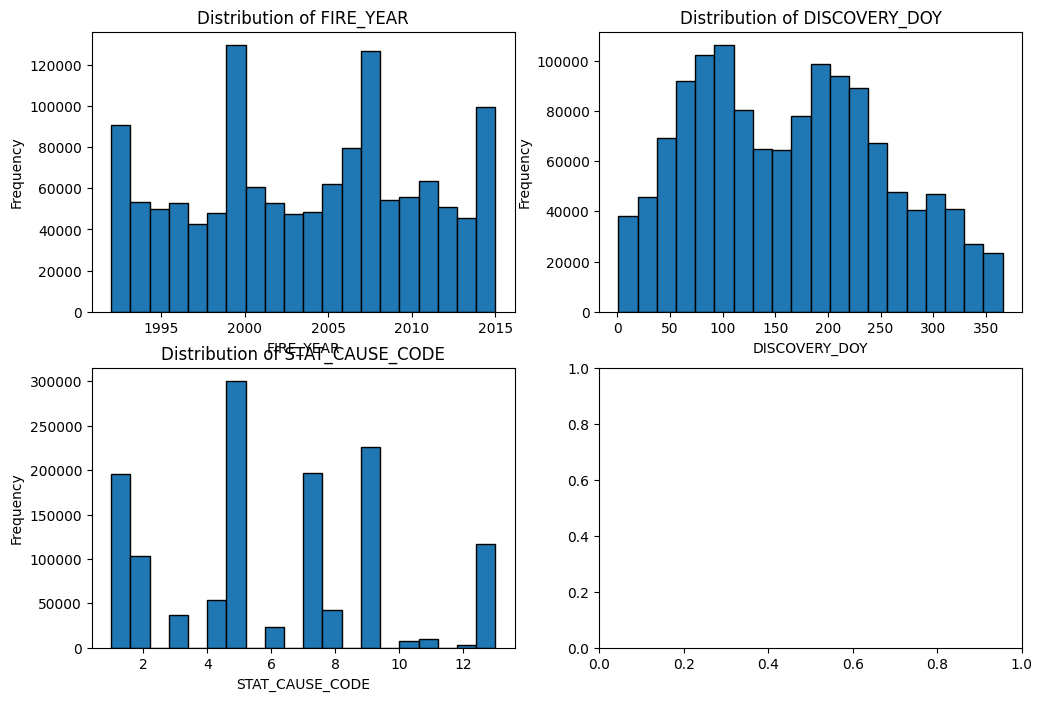

In [80]:
import matplotlib.pyplot as plt
df=train_data.toPandas()
# Select the features for plotting
features_to_plot = ['FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'STATE_ENCODED']

# Create subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot histograms for each feature
for ax, feature in zip(axes.flatten(), features_to_plot):
    ax.hist(df[feature], bins=20, edgecolor='black')
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [64]:
accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix = logistic_reg_classifier_2(my_df, 'FIRE_SIZE_CLASS')

print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}, \n"
      f"classification_metrics: \n"
       f"{classification_metrics}")

Acuuracy = 0.5053613359534063
f1_score = 0.4311207784883252, 
weighted_Precision = 0.4167271882129583, 
weighted_Recall = 0.5053613359534063, 
confusionMatrix: 
prediction                0.0    1.0
FIRE_SIZE_CLASS_index               
0.0                    237391  44326
1.0                    152426  47558
2.0                     54768  11093
3.0                      6656   1926
4.0                      2998   1223
5.0                      1487    890
6.0                       531    579, 
classification_metrics: 
              precision    recall  f1-score   support

           0       0.38      0.17      0.23    200462
           1       0.46      0.04      0.07    281558
           2       0.15      0.47      0.23     65831
           3       0.01      0.08      0.03      8549
           4       0.01      0.03      0.01      4306
           5       0.00      0.09      0.01      2337
           6       0.01      0.65      0.01      1097

    accuracy                           0.14  

In [58]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [6]:
my_df = data_reader(df_spark)

In [70]:
STATE_indexer, assembler, indexed_df, outputCol = classifier_data_prep('FIRE_SIZE_CLASS', my_df)
indexed_df.show()

+---------------+-----+---------+-------------+---------------+---------------------+
|FIRE_SIZE_CLASS|STATE|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|FIRE_SIZE_CLASS_index|
+---------------+-----+---------+-------------+---------------+---------------------+
|              A|   CA|     2005|           33|              9|                  1.0|
|              A|   CA|     2004|          133|              1|                  1.0|
|              A|   CA|     2004|          152|              5|                  1.0|
|              A|   CA|     2004|          180|              1|                  1.0|
|              A|   CA|     2004|          180|              1|                  1.0|
|              A|   CA|     2004|          182|              1|                  1.0|
|              A|   CA|     2004|          183|              1|                  1.0|
|              B|   CA|     2005|           67|              5|                  0.0|
|              B|   CA|     2005|           74|       

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
import sys
sys.setrecursionlimit(1500)  # Increase the recursion limit as per your requirement

def classifier_data_prep(label, df):
    desired_cols = ['FIRE_SIZE_CLASS',  'FIRE_YEAR', 'STATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE'] # 
    df_final = df[desired_cols]

    outputCol = label + '_index'
    indexer = LabelEncoder()

    df_final['STATE_ENCODED'] = indexer.fit_transform(df_final['STATE'])
    #df_final.loc[:, 'STATE_ENCODED'] = indexer.fit_transform(df_final['STATE'])

    
    indexed_labels = indexer.fit_transform(df_final[label])
    
    features = df_final.drop([label, 'STATE'], axis=1)

    return features, indexed_labels, indexer

def logistic_reg_classifier(df, label):
    features, indexed_labels, indexer = classifier_data_prep(label, df)

    # Split the dataset into training and testing
    train_features, test_features, train_labels, test_labels = train_test_split(features, indexed_labels, test_size=0.3, random_state=42)

    # Oversample the training data using SMOTE
    oversampler = SMOTE()
    train_features_oversampled, train_labels_oversampled = oversampler.fit_resample(train_features, train_labels)

    # Define the logistic regression model
    log_reg_model = LogisticRegression()

    # Fit the logistic regression model on the oversampled training data
    log_reg_model.fit(train_features_oversampled, train_labels_oversampled)

    # Make predictions on the testing data
    predictions = log_reg_model.predict(test_features)

    # Calculate evaluation metrics
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average='weighted')
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')

    # Compute confusion matrix
    confusion_matrix_df = pd.DataFrame(confusion_matrix(test_labels, predictions), index=indexer.classes_, columns=indexer.classes_)
    
    #predicted_labels = np.argmax(predictions, axis=1)
    predicted_labels = predictions
    actual_labels = test_labels


    classification_metrics = classification_report(actual_labels, predicted_labels)

    return accuracy, f1, precision, recall, confusion_matrix_df, classification_metrics
    #return train_features_oversampled, train_labels_oversampled

# Assuming 'actual_labels' and 'predicted_labels' are defined as mentioned before

# Calculate classification metrics




In [7]:
my_df.toPandas()

,LONGITUDE,LATITUDE,FIRE_SIZE,FIRE_SIZE_CLASS,STATE,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,DISCOVERY_TIME,CONT_TIME
0,-121.005833330000000000,40.036944440000000000,0.10,A,CA,2005,33,9,1300,1730
1,-120.404444440000000000,38.933055560000000000,0.25,A,CA,2004,133,1,0845,1530
2,-120.735555560000000000,38.984166670000000000,0.10,A,CA,2004,152,5,1921,2024
3,-119.913333330000000000,38.559166670000000000,0.10,A,CA,2004,180,1,1600,1400
4,-119.933055560000000000,38.559166670000000000,0.10,A,CA,2004,180,1,1600,1200
...,...,...,...,...,...,...,...,...,...,...
1880460,-122.389375000000000000,40.481637000000000000,0.01,A,CA,2015,269,13,1726,1843
1880461,-120.938570200000000000,37.617619160000000000,0.20,A,CA,2015,278,9,0126,None
1880462,-120.938570200000000000,37.617619160000000000,0.10,A,CA,2015,122,13,2052,None
1880463,-120.898356050000000000,37.672234690000000000,2.00,B,CA,2015,287,13,2309,None


In [8]:
features, indexed_labels, indexer = classifier_data_prep('FIRE_SIZE_CLASS', my_df.toPandas())

C:\Users\dania\AppData\Local\Temp\ipykernel_14136\3782922956.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['STATE_ENCODED'] = indexer.fit_transform(df_final['STATE'])


In [9]:
features

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STATE_ENCODED
0,2005,33,9,4
1,2004,133,1,4
2,2004,152,5,4
3,2004,180,1,4
4,2004,180,1,4
...,...,...,...,...
1880460,2015,269,13,4
1880461,2015,278,9,4
1880462,2015,122,13,4
1880463,2015,287,13,4


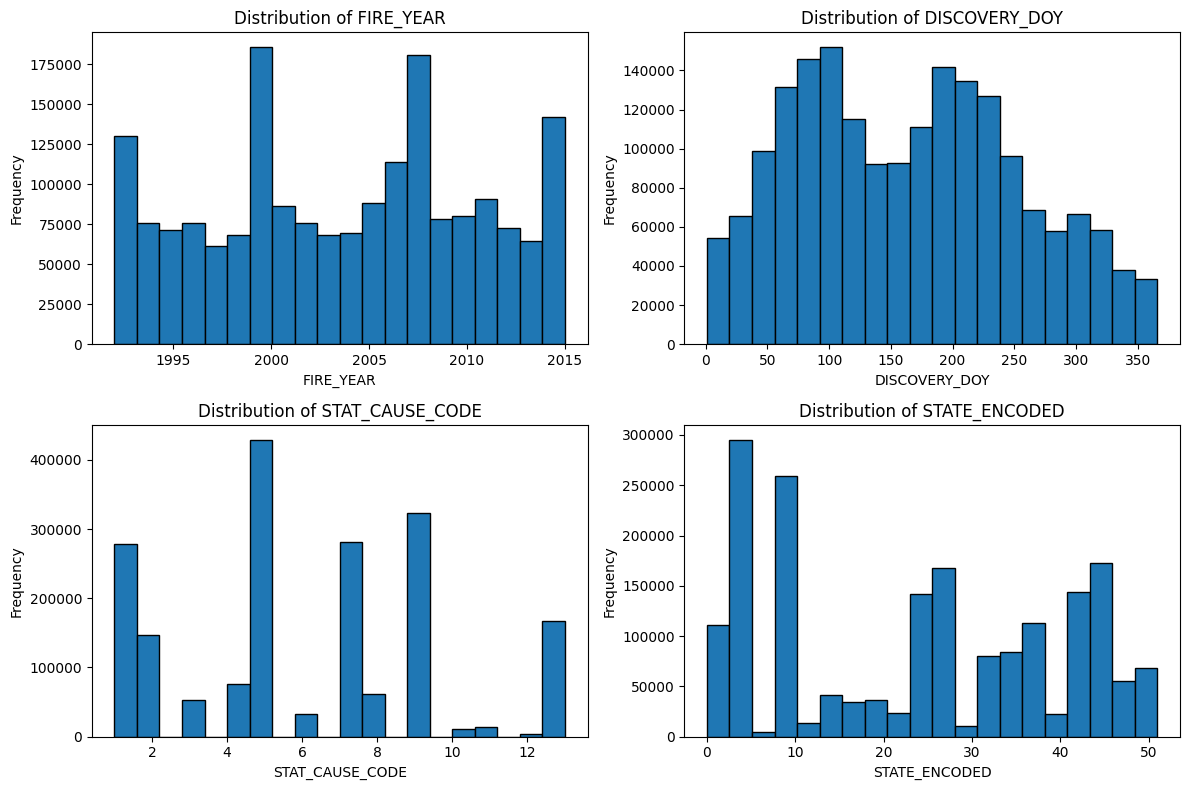

In [43]:
import matplotlib.pyplot as plt
df=features
# Select the features for plotting
features_to_plot = ['FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'STATE_ENCODED']

# Create subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot histograms for each feature
for ax, feature in zip(axes.flatten(), features_to_plot):
    ax.hist(df[feature], bins=20, edgecolor='black')
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

import sys
sys.setrecursionlimit(1500)  # Increase the recursion limit as per your requirement

def classifier_data_prep(label, df):
    desired_cols = ['FIRE_SIZE_CLASS', 'FIRE_YEAR', 'STATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE']
    df_final = df[desired_cols]

    outputCol = label + '_index'
    indexer = LabelEncoder()

    df_final['STATE_ENCODED'] = indexer.fit_transform(df_final['STATE'])

    indexed_labels = indexer.fit_transform(df_final[label])

    numerical_features = ['FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'STATE_ENCODED']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_final[numerical_features])
    df_scaled = pd.DataFrame(scaled_features, columns=numerical_features)

    #features = df_scaled.drop(label, axis=1)
    features = df_scaled
    return features, indexed_labels, indexer

def logistic_reg_classifier(df, label):
    features, indexed_labels, indexer = classifier_data_prep(label, df)

    # Split the dataset into training and testing
    train_features, test_features, train_labels, test_labels = train_test_split(features, indexed_labels, test_size=0.3, random_state=42)

    # Oversample the training data using SMOTE
    oversampler = SMOTE()
    train_features_oversampled, train_labels_oversampled = oversampler.fit_resample(train_features, train_labels)

    # Define the logistic regression model
    log_reg_model = LogisticRegression()

    # Fit the logistic regression model on the oversampled training data
    log_reg_model.fit(train_features_oversampled, train_labels_oversampled)

    # Make predictions on the testing data
    predictions = log_reg_model.predict(test_features)

    # Calculate evaluation metrics
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average='weighted')
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')

    # Compute confusion matrix
    confusion_matrix_df = pd.DataFrame(confusion_matrix(test_labels, predictions), index=indexer.classes_, columns=indexer.classes_)

    predicted_labels = predictions
    actual_labels = test_labels

    classification_metrics = classification_report(actual_labels, predicted_labels)

    return accuracy, f1, precision, recall, confusion_matrix_df, classification_metrics


In [51]:
features, indexed_labels, indexer = classifier_data_prep('FIRE_SIZE_CLASS', my_df.toPandas())

C:\Users\dania\AppData\Local\Temp\ipykernel_14136\2194091889.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['STATE_ENCODED'] = indexer.fit_transform(df_final['STATE'])


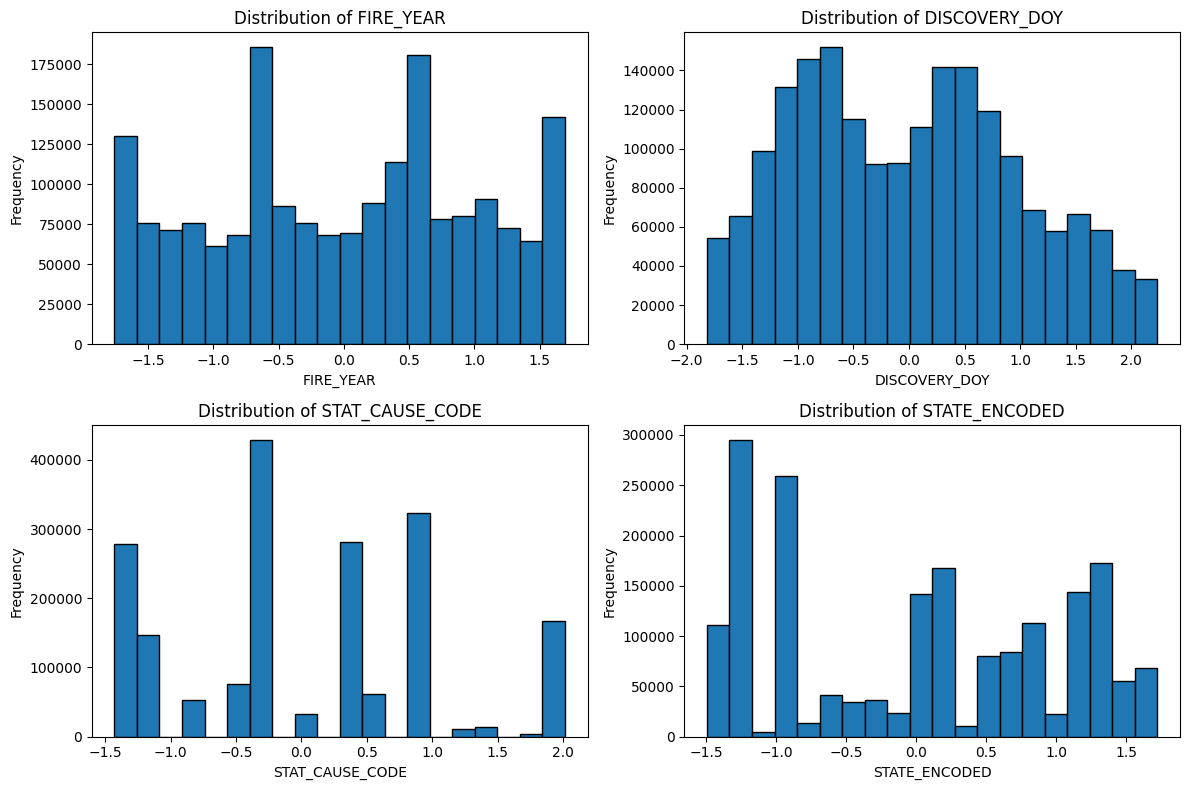

In [52]:
import matplotlib.pyplot as plt
df=features
# Select the features for plotting
features_to_plot = ['FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'STATE_ENCODED']

# Create subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot histograms for each feature
for ax, feature in zip(axes.flatten(), features_to_plot):
    ax.hist(df[feature], bins=20, edgecolor='black')
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [18]:
len(features.STATE_ENCODED.unique())

52

In [13]:
np.unique(indexed_labels)

array([0, 1, 2, 3, 4, 5, 6])

In [27]:
unique_values, counts = np.unique(indexed_labels, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 666919
1: 939376
2: 220077
3: 28427
4: 14107
5: 7786
6: 3773


In [22]:
train_features_oversampled, train_labels_oversampled = logistic_reg_classifier(my_df.toPandas(), 'FIRE_SIZE_CLASS')

C:\Users\dania\AppData\Local\Temp\ipykernel_14136\2763190568.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['STATE_ENCODED'] = indexer.fit_transform(df_final['STATE'])
C:\Users\dania\anaconda3\envs\gpufordl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
unique_values, counts = np.unique(train_labels_oversampled, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}") 

0: 657818
1: 657818
2: 657818
3: 657818
4: 657818
5: 657818
6: 657818


In [36]:
len(train_labels_oversampled)

4604726

In [60]:
accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix, classification_metrics = logistic_reg_classifier(my_df.toPandas(), 'FIRE_SIZE_CLASS')

AttributeError: 'DataFrame' object has no attribute 'select'

In [54]:
print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}, \n"
      f"classification_metrics: \n"
       f"{classification_metrics}")

Acuuracy = 0.1373400219803595
f1_score = 0.14577119276084124, 
weighted_Precision = 0.3827697842901517, 
weighted_Recall = 0.1373400219803595, 
confusionMatrix: 
       A      B       C      D      E      F      G
A  33548  10320   48265  17816   7900  17936  64677
B  44218  10937  118307  24434  10443  20336  52883
C   9286   1778   31211   4739   1984   4234  12599
D   1156    271    3211    718    287    601   2305
E    507    230    1200    357    146    329   1537
F    249    109     435    197     82    201   1064
G     81     24     106     64     22     82    718, 
classification_metrics: 
              precision    recall  f1-score   support

           0       0.38      0.17      0.23    200462
           1       0.46      0.04      0.07    281558
           2       0.15      0.47      0.23     65831
           3       0.01      0.08      0.03      8549
           4       0.01      0.03      0.01      4306
           5       0.00      0.09      0.01      2337
           6    

In [29]:
# this is only for visualizing the procceced data

STATE_indexer, assembler, indexed_df, outputCol = classifier_data_prep('FIRE_SIZE_CLASS', my_df)

indexed_df_state_index = STATE_indexer.fit(indexed_df).transform(indexed_df)


inputCols = [ 'STATE_Index','FIRE_YEAR', 'DISCOVERY_DOY',
                                  'STAT_CAUSE_CODE']


assembler = VectorAssembler(inputCols=inputCols, outputCol='features')

output = assembler.transform(indexed_df_state_index)
for item in output.select('features').head(5):
    print (item)

RecursionError: maximum recursion depth exceeded in comparison

In [37]:
output.select('features').head(5)[1]

Row(features=DenseVector([0.0, 2004.0, 133.0, 1.0]))

In [28]:
output.show()  

NameError: name 'output' is not defined

In [42]:
type(output)

pyspark.sql.dataframe.DataFrame

In [58]:
accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix = logistic_reg_classifier(my_df, 'FIRE_SIZE_CLASS')

RecursionError: maximum recursion depth exceeded in comparison

In [60]:
print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}")

Acuuracy = 0.5049948977328187
f1_score = 0.4308402611456908, 
weighted_Precision = 0.4161678754254019, 
weighted_Recall = 0.5049948977328187, 
confusionMatrix: 
prediction                0.0    1.0
FIRE_SIZE_CLASS_index               
0.0                    237272  44669
1.0                    152293  47280
2.0                     54987  10896
3.0                      6513   1921
4.0                      2964   1214
5.0                      1418    900
6.0                       556    592


In [68]:
accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix = logistic_reg_classifier(data, 'STAT_CAUSE_CODE')

In [69]:
print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}")a

Acuuracy = 0.23831392604527854
f1_score = 0.16868510955013774, 
weighted_Precision = 0.1729489684147902, 
weighted_Recall = 0.23831392604527854, 
confusionMatrix: 
prediction               0.0    1.0   2.0    3.0   4.0
STAT_CAUSE_CODE_index                                 
0.0                    87203  11724  2962  22663  4293
1.0                    58729  15429  1232  18339  3163
2.0                    54520   5891  2538  19959  1521
3.0                    37750  17033  1568  26925   250
4.0                    29337   5153  1183  11662  2203
5.0                    27047   6041   578   9717   796
6.0                    11534   3345   484   6754   795
7.0                    12199   1263   708   3692   426
8.0                     9515   1448   391   4114   480
9.0                     7257    377   178   1962   252
10.0                    2313   1155    57    694   136
11.0                    1776    726   140    757    41
12.0                     552    162    50    339    53


In [8]:
def rf_classifier(df, label, maxDepth):
    
    STATE_indexer, assembler, label_indexed_df, outputCol = classifier_data_prep (label, df)
    
    rfc = RandomForestClassifier(labelCol=outputCol,maxDepth = maxDepth, maxBins=52)
    
    pipeline_rfc = Pipeline(stages=[STATE_indexer, assembler, rfc])
    
    train_data, test_data = label_indexed_df.randomSplit([0.7, 0.3])

    rfc_model = pipeline_rfc.fit(train_data)
    
    predictions_rfc = rfc_model.transform(test_data)
    
    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="accuracy")
    accuracy = evaluator.evaluate(predictions_rfc)
    
    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="f1")
    f_1_score = evaluator.evaluate(predictions_rfc)

    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="weightedPrecision")
    weighted_Precision = evaluator.evaluate(predictions_rfc)
    
    evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="weightedRecall")
    weighted_Recall = evaluator.evaluate(predictions_rfc)
    
    # Compute confusion matrix
    predictionAndLabels = predictions_rfc.select("prediction", outputCol)
    confusionMatrix = predictionAndLabels.groupBy(outputCol, "prediction").count()

    # Collect the confusion matrix into a Pandas DataFrame
    confusionMatrix = confusionMatrix.toPandas()

    # Pivot the confusion matrix
    confusionMatrix = confusionMatrix.pivot(index=outputCol, columns="prediction", values="count").fillna(0)

    #return accuracy 
    return accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix


In [78]:
accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix = rf_classifier(data, 'STAT_CAUSE_CODE', 15)

In [80]:
# maxDepth = 15
print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}")

Acuuracy = 0.5089422947522011
f1_score = 0.4685392689974129, 
weighted_Precision = 0.4862418049378175, 
weighted_Recall = 0.5089422947522011, 
confusionMatrix: 
prediction                0.0      1.0      2.0      3.0      4.0     5.0   \
STAT_CAUSE_CODE_index                                                        
0.0                    96433.0   9338.0  14162.0   4919.0   1286.0  1386.0   
1.0                    28213.0  44088.0   6068.0  10902.0   1719.0  4362.0   
2.0                    35184.0  10440.0  30203.0   4022.0   1731.0  2212.0   
3.0                     5560.0   6629.0   1295.0  66711.0    771.0  1652.0   
4.0                     2405.0   2813.0    484.0   6162.0  37633.0    61.0   
5.0                    16969.0   8780.0   2858.0   6506.0    785.0  5895.0   
6.0                     7186.0   4365.0    958.0   7166.0    478.0   581.0   
7.0                     9511.0   2940.0   1747.0   2345.0    255.0   641.0   
8.0                     7031.0   3926.0   1410.0   2199.0  

In [84]:
accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix = rf_classifier(data, 'STAT_CAUSE_CODE', 5)

In [85]:
# maxDepth = 5
print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}")

Acuuracy = 0.3930558579802046
f1_score = 0.297535175321475, 
weighted_Precision = 0.4164518784943356, 
weighted_Recall = 0.3930558579802047, 
confusionMatrix: 
prediction                  0.0      1.0  2.0      3.0      4.0  6.0
STAT_CAUSE_CODE_index                                               
0.0                    109908.0  12090.0  0.0   7033.0    110.0  0.0
1.0                     44557.0  32858.0  3.0  19571.0     77.0  0.0
2.0                     64539.0  13277.0  4.0   6229.0    376.0  0.0
3.0                      8326.0  10749.0  0.0  64782.0      6.0  0.0
4.0                     18538.0   7203.0  0.0   9753.0  14473.0  0.0
5.0                     22677.0  13710.0  0.0   7815.0     21.0  0.0
6.0                      8805.0   4810.0  0.0   9281.0     27.0  4.0
7.0                     11353.0   3825.0  0.0   3069.0     10.0  0.0
8.0                      8675.0   3695.0  0.0   3443.0      7.0  0.0
9.0                      6877.0   1437.0  0.0   1802.0      3.0  0.0
10.0        

In [11]:
accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix = rf_classifier(data, 'STAT_CAUSE_CODE', 10)

In [13]:
# maxDepth = 10
print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}")

Acuuracy = 0.4702473034345728
f1_score = 0.41606156925464427, 
weighted_Precision = 0.4467752094846642, 
weighted_Recall = 0.4702473034345728, 
confusionMatrix: 
prediction                 0.0      1.0      2.0      3.0      4.0    5.0   \
STAT_CAUSE_CODE_index                                                        
0.0                    101233.0   9846.0  10313.0   5337.0    655.0  237.0   
1.0                     35304.0  42593.0   4827.0  11956.0    653.0  545.0   
2.0                     43142.0  12556.0  22376.0   4259.0    967.0  300.0   
3.0                      7150.0   9563.0    990.0  64641.0    355.0  143.0   
4.0                      7653.0   4258.0   1364.0   7587.0  28998.0   12.0   
5.0                     19372.0  12977.0   1758.0   6639.0    347.0  797.0   
6.0                      7845.0   4630.0    797.0   8277.0    312.0   87.0   
7.0                     10091.0   3503.0   1357.0   2706.0    126.0   71.0   
8.0                      7871.0   4001.0   1144.0   2485.0

In [32]:
# let's only consider the first 6 classes for STAT_CAUSE_CODE when STAT_CAUSE_CODE is the target/label 

In [29]:
data.select('STAT_CAUSE_CODE').toPandas().value_counts(normalize=False)

STAT_CAUSE_CODE
5                  429028
9                  323805
7                  281455
1                  278468
13                 166723
2                  147612
4                   76139
8                   61167
3                   52869
6                   33455
11                  14448
10                  11500
12                   3796
dtype: int64

In [33]:
my_data = data.filter((data['STAT_CAUSE_CODE'] == 5) | \
           (data['STAT_CAUSE_CODE'] == 9) |\
           (data['STAT_CAUSE_CODE'] == 7) |\
           (data['STAT_CAUSE_CODE'] == 1) |\
           (data['STAT_CAUSE_CODE'] == 13) |\
           (data['STAT_CAUSE_CODE'] == 2))

In [34]:
accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix = rf_classifier(my_data, 'STAT_CAUSE_CODE', 15)

In [35]:
# maxDepth = 15 my_data
print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}")

Acuuracy = 0.5822371050145401
f1_score = 0.5636917264844861, 
weighted_Precision = 0.5764207975192471, 
weighted_Recall = 0.5822371050145401, 
confusionMatrix: 
prediction               0.0    1.0    2.0    3.0    4.0   5.0
STAT_CAUSE_CODE_index                                         
0.0                    96914   8905  13899   5026   1406  2086
1.0                    29512  43060   5991  11275   2402  5254
2.0                    35691  10086  29913   4195   1958  2672
3.0                     5677   6181   1266  67322   1047  1923
4.0                     2236   2109    567   6079  38809    87
5.0                    17492   8342   2811   6617   1060  8091


In [36]:
my_data_2 = data.filter((data['STAT_CAUSE_CODE'] == 5) | \
           (data['STAT_CAUSE_CODE'] == 9) |\
           (data['STAT_CAUSE_CODE'] == 7))

In [37]:
accuracy, f_1_score, weighted_Precision, weighted_Recall, confusionMatrix = rf_classifier(my_data_2, 'STAT_CAUSE_CODE', 15)

In [38]:
# maxDepth = 15 my_data_2
print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}")

Acuuracy = 0.6149792938977424
f1_score = 0.6047628944877397, 
weighted_Precision = 0.6158839849264293, 
weighted_Recall = 0.6149792938977424, 
confusionMatrix: 
prediction               0.0    1.0    2.0
STAT_CAUSE_CODE_index                     
0.0                    98395  14710  15433
1.0                    30501  59907   6701
2.0                    35692  16433  32523


In [10]:
data = data_reader(df_spark)

In [22]:
classifier(data)

0.5039715919375619

In [26]:
rf_classifier(data)

0.6215927160174662

In [16]:
FIRE_SIZE_CLASS_indexer = StringIndexer(inputCol='FIRE_SIZE_CLASS', outputCol='FIRE_SIZE_CLASS_Index')
FIRE_SIZE_CLASS_indexed = FIRE_SIZE_CLASS_indexer.fit(df_final).transform(df_final)
FIRE_SIZE_CLASS_indexed.head(3)


[Row(FIRE_SIZE_CLASS='A', STATE='CA', FIRE_YEAR=2005, DISCOVERY_DOY=33, STAT_CAUSE_CODE=9, FIRE_SIZE_CLASS_Index=1.0),
 Row(FIRE_SIZE_CLASS='A', STATE='CA', FIRE_YEAR=2004, DISCOVERY_DOY=133, STAT_CAUSE_CODE=1, FIRE_SIZE_CLASS_Index=1.0),
 Row(FIRE_SIZE_CLASS='A', STATE='CA', FIRE_YEAR=2004, DISCOVERY_DOY=152, STAT_CAUSE_CODE=5, FIRE_SIZE_CLASS_Index=1.0)]

In [10]:
FIRE_SIZE_CLASS_indexed.columns

['FIRE_SIZE_CLASS',
 'STATE',
 'FIRE_YEAR',
 'DISCOVERY_DOY',
 'STAT_CAUSE_CODE',
 'FIRE_SIZE_CLASS_Index']

In [122]:
STATE_indexer = StringIndexer(inputCol='STATE', outputCol='STATE_Index')
# STATE_indexed = STATE_indexer.fit(df_final).transform(df_final)
# STATE_indexed.head(3)

In [123]:
assembler = VectorAssembler(inputCols=[ 'STATE_Index','FIRE_YEAR', 'DISCOVERY_DOY',
                                        'STAT_CAUSE_CODE'], outputCol='features')


In [124]:
lin_reg_model = LinearRegression(featuresCol='features', labelCol='FIRE_SIZE')

In [125]:
pipeline_reg = Pipeline(stages=[STATE_indexer, assembler, lin_reg_model])


In [127]:
#for regression
train_data, test_data = df_final.randomSplit([0.7, 0.3])

In [13]:
log_reg_model = LogisticRegression(featuresCol='features', labelCol='FIRE_SIZE_CLASS_Index')

In [14]:
pipeline = Pipeline(stages=[STATE_indexer, assembler, log_reg_model])


In [17]:
train_data, test_data = FIRE_SIZE_CLASS_indexed.randomSplit([0.7, 0.3])

In [35]:
FIRE_SIZE_CLASS_indexed_small = FIRE_SIZE_CLASS_indexed.filter((FIRE_SIZE_CLASS_indexed['FIRE_SIZE_CLASS_Index'] == 0.0) | \
                              (FIRE_SIZE_CLASS_indexed['FIRE_SIZE_CLASS_Index'] == 1.0)|\
                               (FIRE_SIZE_CLASS_indexed['FIRE_SIZE_CLASS_Index'] == 2.0))

In [36]:
small_train_data, small_test_data = FIRE_SIZE_CLASS_indexed_small.randomSplit([0.7, 0.3])

In [16]:
train_data.head()

Row(FIRE_SIZE_CLASS='A', STATE='AK', FIRE_YEAR=1992, DISCOVERY_DOY=95, STAT_CAUSE_CODE=3, FIRE_SIZE_CLASS_Index=1.0)

In [128]:
fit_model_reg = pipeline_reg.fit(train_data)

In [17]:
fit_model = pipeline.fit(train_data)

In [129]:
predictions = fit_model_reg.transform(test_data)

In [130]:
predicted_actual = predictions.select("prediction", "FIRE_SIZE")
predicted_actual.show()

+------------------+---------+
|        prediction|FIRE_SIZE|
+------------------+---------+
| 160.7257437982953|   9.0E-5|
|197.63551705141163|   1.0E-4|
|234.97552058782185|   1.0E-4|
|179.70152480295292|   3.4E-4|
|179.70152480295292|   3.4E-4|
|201.61400576911365|   4.0E-4|
|  279.291113557897|  4.59E-4|
|108.62682482219589|    0.001|
|112.53254491221833|    0.001|
|120.26428937140008|    0.001|
|152.53297632354224|    0.001|
|130.04127326264916|    0.001|
|157.39459900180918|    0.001|
|144.34644647148798|    0.001|
|164.36701723847546|    0.001|
| 233.7968065533032|    0.001|
|192.60971718302517|    0.001|
|184.31258888353295|    0.001|
| 276.9536094190744|    0.001|
|210.26078812485684|    0.001|
+------------------+---------+
only showing top 20 rows



In [131]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="FIRE_SIZE", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predicted_actual)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 2423.210691331175


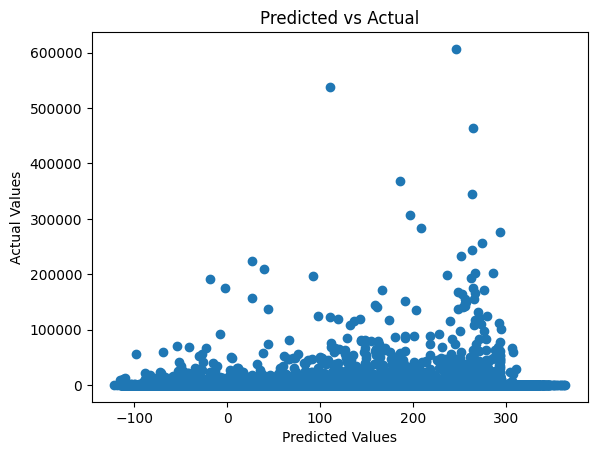

In [132]:
import matplotlib.pyplot as plt

# Get the predicted and actual values
predictions = fit_model_reg.transform(test_data).select('prediction').toPandas().values.flatten()#.rdd.flatMap(lambda x: x).collect()
actual = test_data.select('FIRE_SIZE').toPandas().values.flatten()#.rdd.flatMap(lambda x: x).collect()

# Create a scatter plot
plt.scatter(predictions, actual)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual')
plt.show()


In [133]:
predictions.show()

AttributeError: 'numpy.ndarray' object has no attribute 'show'

In [83]:
actual.show()

+---------+
|FIRE_SIZE|
+---------+
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
|      1.0|
+---------+
only showing top 20 rows



In [24]:
predictions = fit_model.transform(test_data)

In [63]:
predictions.columns

['FIRE_SIZE',
 'STATE',
 'FIRE_YEAR',
 'DISCOVERY_DOY',
 'STAT_CAUSE_CODE',
 'STATE_Index',
 'features',
 'prediction']

In [64]:
predictions.select('prediction', 'FIRE_SIZE').show()

+------------------+---------+
|        prediction|FIRE_SIZE|
+------------------+---------+
|1.0000000000004279|      1.0|
|1.0000000000004279|      1.0|
|1.0000000000004279|      1.0|
|1.0000000000004277|      1.0|
|1.0000000000004274|      1.0|
|1.0000000000004274|      1.0|
|1.0000000000004274|      1.0|
|1.0000000000004274|      1.0|
|1.0000000000004274|      1.0|
|1.0000000000004274|      1.0|
|1.0000000000004272|      1.0|
|1.0000000000004272|      1.0|
|1.0000000000004272|      1.0|
|1.0000000000004272|      1.0|
|1.0000000000004272|      1.0|
| 1.000000000000427|      1.0|
|1.0000000000004268|      1.0|
|1.0000000000004268|      1.0|
|1.0000000000004268|      1.0|
|1.0000000000004268|      1.0|
+------------------+---------+
only showing top 20 rows



In [26]:
predictions.select('prediction', 'FIRE_SIZE_CLASS_Index').show()

+----------+---------------------+
|prediction|FIRE_SIZE_CLASS_Index|
+----------+---------------------+
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
|       0.0|                  1.0|
+----------+---------------------+
only showing top 20 rows



In [30]:
evaluator = MulticlassClassificationEvaluator(labelCol="FIRE_SIZE_CLASS_Index", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)


print (f"Accuracy is {accuracy:.4f}")


Accuracy is 0.5043


In [41]:
evaluator = MulticlassClassificationEvaluator(labelCol="FIRE_SIZE_CLASS_Index", metricName="f1")
f_1_score = evaluator.evaluate(predictions)


print (f"The f1 score is {f_1_score:.4f}")


The f1 score is 0.4306


In [34]:
evaluator = MulticlassClassificationEvaluator(labelCol="FIRE_SIZE_CLASS_Index", metricName="weightedPrecision")
weighted_Precision = evaluator.evaluate(predictions)


print (f"The weighted Precision is {weighted_Precision:.4f}")


The weighted Precision is 0.4153


In [35]:
evaluator = MulticlassClassificationEvaluator(labelCol="FIRE_SIZE_CLASS_Index", metricName="weightedRecall")
weighted_Recall = evaluator.evaluate(predictions)


print (f"The weighted Recall is {weighted_Recall:.4f}")


The weighted Recall is 0.5043


In [44]:
# Compute confusion matrix
predictionAndLabels = predictions.select("prediction", "FIRE_SIZE_CLASS_Index")
confusionMatrix = predictionAndLabels.groupBy("FIRE_SIZE_CLASS_Index", "prediction").count()

# Collect the confusion matrix into a Pandas DataFrame
confusionMatrix = confusionMatrix.toPandas()

# Pivot the confusion matrix
confusionMatrix = confusionMatrix.pivot(index="FIRE_SIZE_CLASS_Index", columns="prediction", values="count").fillna(0)

# Display confusion matrix
confusionMatrix

prediction,0.0,1.0
FIRE_SIZE_CLASS_Index,,
0.0,236588,45198
1.0,151868,47713
2.0,54994,11197
3.0,6497,1981
4.0,3055,1237
5.0,1442,841
6.0,543,559


In [9]:
dtc = DecisionTreeClassifier(labelCol='FIRE_SIZE_CLASS_Index', maxBins=52)
rfc = RandomForestClassifier(labelCol='FIRE_SIZE_CLASS_Index',maxDepth=15, maxBins=52)
#gbt = GBTClassifier(labelCol='FIRE_SIZE_CLASS_Index', maxBins=52)

In [99]:
pipeline_dtc = Pipeline(stages=[STATE_indexer, assembler, dtc])

In [13]:
pipeline_rfc = Pipeline(stages=[STATE_indexer, assembler, rfc])

In [18]:
rfc_model = pipeline_rfc.fit(train_data)

In [37]:
rfc_model = pipeline_rfc.fit(small_train_data)

In [101]:
dtc_model = pipeline_dtc.fit(train_data)

In [38]:
predictions_rfc = rfc_model.transform(test_data)

In [39]:
predictions_rfc = rfc_model.transform(small_test_data)

In [102]:
predictions_dtc = dtc_model.transform(test_data)

In [103]:
evaluator = MulticlassClassificationEvaluator(labelCol="FIRE_SIZE_CLASS_Index", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_dtc)


print (f"Accuracy is {accuracy:.4f}")


Accuracy is 0.5766


In [104]:
# Compute confusion matrix
predictionAndLabels = predictions_dtc.select("prediction", "FIRE_SIZE_CLASS_Index")
confusionMatrix = predictionAndLabels.groupBy("FIRE_SIZE_CLASS_Index", "prediction").count()

# Collect the confusion matrix into a Pandas DataFrame
confusionMatrix = confusionMatrix.toPandas()

# Pivot the confusion matrix
confusionMatrix = confusionMatrix.pivot(index="FIRE_SIZE_CLASS_Index", columns="prediction", values="count").fillna(0)

# Display confusion matrix
confusionMatrix 



prediction,0.0,1.0
FIRE_SIZE_CLASS_Index,,
0.0,245836,35950
1.0,120363,79218
2.0,60264,5927
3.0,7104,1374
4.0,3284,1008
5.0,1546,737
6.0,667,435


In [40]:
evaluator = MulticlassClassificationEvaluator(labelCol="FIRE_SIZE_CLASS_Index", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rfc)


print (f"Accuracy is {accuracy:.4f}")


Accuracy is 0.6397


In [41]:
# Compute confusion matrix
predictionAndLabels = predictions_rfc.select("prediction", "FIRE_SIZE_CLASS_Index")
confusionMatrix = predictionAndLabels.groupBy("FIRE_SIZE_CLASS_Index", "prediction").count()

# Collect the confusion matrix into a Pandas DataFrame
confusionMatrix = confusionMatrix.toPandas()

# Pivot the confusion matrix
confusionMatrix = confusionMatrix.pivot(index="FIRE_SIZE_CLASS_Index", columns="prediction", values="count").fillna(0)

# Display confusion matrix
confusionMatrix 



prediction,0.0,1.0,2.0
FIRE_SIZE_CLASS_Index,,,
0.0,229636,51239,983
1.0,80220,119621,143
2.0,56788,7979,1196


In [129]:
train_data.printSchema()

root
 |-- FIRE_SIZE_CLASS: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- FIRE_YEAR: integer (nullable = true)
 |-- DISCOVERY_DOY: integer (nullable = true)
 |-- STAT_CAUSE_CODE: integer (nullable = true)
 |-- FIRE_SIZE_CLASS_Index: double (nullable = false)



In [136]:
assembler = VectorAssembler(inputCols=[ 'STATE_Index','FIRE_YEAR', 'DISCOVERY_DOY',
                                        'STAT_CAUSE_CODE'], outputCol='features')


In [139]:
STATE_indexer = StringIndexer(inputCol='STATE', outputCol='STATE_Index')
STATE_indexed = STATE_indexer.fit(df_final).transform(df_final)



In [140]:
FIRE_SIZE_CLASS_indexer = StringIndexer(inputCol='FIRE_SIZE_CLASS', outputCol='FIRE_SIZE_CLASS_Index')
FIRE_SIZE_CLASS_indexed = FIRE_SIZE_CLASS_indexer.fit(STATE_indexed).transform(STATE_indexed)
# FIRE_SIZE_CLASS_indexed.head(3)


In [141]:
output = assembler.transform(FIRE_SIZE_CLASS_indexed)


In [142]:
output.show()

+---------------+-----+---------+-------------+---------------+-----------+---------------------+--------------------+
|FIRE_SIZE_CLASS|STATE|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|STATE_Index|FIRE_SIZE_CLASS_Index|            features|
+---------------+-----+---------+-------------+---------------+-----------+---------------------+--------------------+
|              A|   CA|     2005|           33|              9|        0.0|                  1.0|[0.0,2005.0,33.0,...|
|              A|   CA|     2004|          133|              1|        0.0|                  1.0|[0.0,2004.0,133.0...|
|              A|   CA|     2004|          152|              5|        0.0|                  1.0|[0.0,2004.0,152.0...|
|              A|   CA|     2004|          180|              1|        0.0|                  1.0|[0.0,2004.0,180.0...|
|              A|   CA|     2004|          180|              1|        0.0|                  1.0|[0.0,2004.0,180.0...|
|              A|   CA|     2004|          182| 

In [156]:
FIRE_SIZE_CLASS_indexed.show()

+---------------+-----+---------+-------------+---------------+-----------+---------------------+
|FIRE_SIZE_CLASS|STATE|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|STATE_Index|FIRE_SIZE_CLASS_Index|
+---------------+-----+---------+-------------+---------------+-----------+---------------------+
|              A|   CA|     2005|           33|              9|        0.0|                  1.0|
|              A|   CA|     2004|          133|              1|        0.0|                  1.0|
|              A|   CA|     2004|          152|              5|        0.0|                  1.0|
|              A|   CA|     2004|          180|              1|        0.0|                  1.0|
|              A|   CA|     2004|          180|              1|        0.0|                  1.0|
|              A|   CA|     2004|          182|              1|        0.0|                  1.0|
|              A|   CA|     2004|          183|              1|        0.0|                  1.0|
|              B|   

In [157]:
data = FIRE_SIZE_CLASS_indexed.select('FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'STATE_Index','FIRE_SIZE_CLASS_Index')

In [248]:
data.show()

+---------+-------------+---------------+-----------+---------------------+
|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|STATE_Index|FIRE_SIZE_CLASS_Index|
+---------+-------------+---------------+-----------+---------------------+
|     2005|           33|              9|        0.0|                  1.0|
|     2004|          133|              1|        0.0|                  1.0|
|     2004|          152|              5|        0.0|                  1.0|
|     2004|          180|              1|        0.0|                  1.0|
|     2004|          180|              1|        0.0|                  1.0|
|     2004|          182|              1|        0.0|                  1.0|
|     2004|          183|              1|        0.0|                  1.0|
|     2005|           67|              5|        0.0|                  0.0|
|     2005|           74|              5|        0.0|                  0.0|
|     2004|          183|              1|        0.0|                  1.0|
|     2004| 

In [158]:
train_data, test_data = data.randomSplit([0.7, 0.3])

In [159]:
train_data.dtypes

[('FIRE_YEAR', 'int'),
 ('DISCOVERY_DOY', 'int'),
 ('STAT_CAUSE_CODE', 'int'),
 ('STATE_Index', 'double'),
 ('FIRE_SIZE_CLASS_Index', 'double')]

In [160]:
train_data.show()

+---------+-------------+---------------+-----------+---------------------+
|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|STATE_Index|FIRE_SIZE_CLASS_Index|
+---------+-------------+---------------+-----------+---------------------+
|     1992|            1|              1|        0.0|                  1.0|
|     1992|            1|              1|       32.0|                  4.0|
|     1992|            1|              2|        4.0|                  0.0|
|     1992|            1|              2|        4.0|                  0.0|
|     1992|            1|              2|        7.0|                  0.0|
|     1992|            1|              3|        1.0|                  0.0|
|     1992|            1|              3|        1.0|                  0.0|
|     1992|            1|              5|        0.0|                  0.0|
|     1992|            1|              5|        2.0|                  0.0|
|     1992|            1|              5|        2.0|                  0.0|
|     1992| 

In [164]:
train_data_pd

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STATE_Index,FIRE_SIZE_CLASS_Index
0,1992,1,1,0.0,1.0
1,1992,1,1,32.0,4.0
2,1992,1,2,4.0,0.0
3,1992,1,2,4.0,0.0
4,1992,1,2,7.0,0.0
...,...,...,...,...,...
1317175,2015,365,13,0.0,1.0
1317176,2015,365,13,0.0,1.0
1317177,2015,365,13,8.0,1.0
1317178,2015,365,13,8.0,1.0


In [165]:
train_data_pd.drop('FIRE_SIZE_CLASS_Index', axis = 1)

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STATE_Index
0,1992,1,1,0.0
1,1992,1,1,32.0
2,1992,1,2,4.0
3,1992,1,2,4.0
4,1992,1,2,7.0
...,...,...,...,...
1317175,2015,365,13,0.0
1317176,2015,365,13,0.0
1317177,2015,365,13,8.0
1317178,2015,365,13,8.0


In [166]:
train_data_pd = train_data.toPandas()



# Create the DMatrix from the Pandas DataFrame
dtrain = xgb.DMatrix(train_data_pd.drop('FIRE_SIZE_CLASS_Index', axis = 1), label=train_data_pd['FIRE_SIZE_CLASS_Index'])#, enable_categorical=True)


In [173]:
test_data_pd = test_data.toPandas()



# Create the DMatrix from the Pandas DataFrame
dtest = xgb.DMatrix(test_data_pd.drop('FIRE_SIZE_CLASS_Index', axis = 1), label=test_data_pd['FIRE_SIZE_CLASS_Index'])#, enable_categorical=True)


In [300]:
xgb_params = {
    "objective": "multi:softprob",
    "num_class": 7,
    "max_depth": 20,
    "eta": 1.0,
#     "num_round": 10
}

xgb_model = xgb.train (dtrain=dtrain, params = xgb_params)

In [301]:
preds = xgb_model.predict(dtest)

In [302]:
preds

array([[9.7079021e-01, 2.5977165e-02, 2.1761740e-03, ..., 1.6835867e-04,
        1.5543895e-04, 1.5390667e-04],
       [9.7079021e-01, 2.5977165e-02, 2.1761740e-03, ..., 1.6835867e-04,
        1.5543895e-04, 1.5390667e-04],
       [9.1283751e-01, 4.1302007e-02, 3.3549190e-02, ..., 1.5022806e-03,
        6.0506063e-03, 3.1087466e-04],
       ...,
       [6.0772163e-01, 1.3171239e-01, 2.4166501e-01, ..., 6.9582099e-03,
        1.6806581e-03, 2.9534835e-03],
       [1.6614597e-03, 9.9315709e-01, 1.0049579e-03, ..., 9.2655078e-05,
        3.8863150e-03, 6.9152724e-05],
       [1.6614597e-03, 9.9315709e-01, 1.0049579e-03, ..., 9.2655078e-05,
        3.8863150e-03, 6.9152724e-05]], dtype=float32)

In [303]:
predicted_labels = np.argmax(preds, axis=1)
predicted_labels

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [304]:
pd.DataFrame(predicted_labels)[0].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [305]:
pd.DataFrame(predicted_labels)

,0
0,0
1,0
2,0
3,1
4,0
...,...
563280,1
563281,1
563282,0
563283,1


In [306]:
test_data_pd

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STATE_Index,FIRE_SIZE_CLASS_Index
0,1992,1,2,1.0,1.0
1,1992,1,2,1.0,1.0
2,1992,1,2,2.0,2.0
3,1992,1,2,21.0,1.0
4,1992,1,3,1.0,1.0
...,...,...,...,...,...
563280,2015,365,7,1.0,1.0
563281,2015,365,7,14.0,0.0
563282,2015,365,9,32.0,1.0
563283,2015,365,13,8.0,1.0


In [307]:
actual_labels = test_data_pd['FIRE_SIZE_CLASS_Index'].values
accuracy = np.mean(predicted_labels == actual_labels)
print("Accuracy:", accuracy)


Accuracy: 0.5978252571966234


In [308]:
from sklearn.metrics import classification_report

# Assuming 'actual_labels' and 'predicted_labels' are defined as mentioned before

# Calculate classification metrics
classification_metrics = classification_report(actual_labels, predicted_labels)

print(classification_metrics)


              precision    recall  f1-score   support

         0.0       0.61      0.73      0.67    281503
         1.0       0.62      0.61      0.61    199552
         2.0       0.31      0.12      0.18     65993
         3.0       0.15      0.02      0.03      8603
         4.0       0.13      0.02      0.03      4245
         5.0       0.10      0.02      0.03      2261
         6.0       0.24      0.08      0.12      1128

    accuracy                           0.60    563285
   macro avg       0.31      0.23      0.24    563285
weighted avg       0.57      0.60      0.57    563285



The precision, recall, and F1-score for classes 3, 4, and 5 are all reported as 0, indicating that there were no true positive predictions for these classes. The support for these classes also seems to be low, suggesting that there might be a limited number of instances in the dataset that belong to those classes.

In the context of classification metrics, the term "support" refers to the number of instances or samples in the dataset that belong to a particular class. It represents the frequency or count of instances in each class.



In [241]:
test_data.groupBy('FIRE_SIZE_CLASS_Index').count().show()

+---------------------+------+
|FIRE_SIZE_CLASS_Index| count|
+---------------------+------+
|                  0.0|281503|
|                  1.0|199552|
|                  4.0|  4245|
|                  3.0|  8603|
|                  2.0| 65993|
|                  6.0|  1128|
|                  5.0|  2261|
+---------------------+------+



# Let's deal with the imbalanced data

It's important to note that oversampling and undersampling should be applied only on the training data to avoid introducing bias into the testing or validation sets. Additionally, the choice between oversampling and undersampling depends on the specific problem and dataset, so it's recommended to experiment with both approaches and evaluate their impact on your model's performance.

In [252]:
# oversampling 
# Assuming X_train and y_train are your training data and labels
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_data_pd.drop('FIRE_SIZE_CLASS_Index', axis=1), train_data_pd['FIRE_SIZE_CLASS_Index'])


In [257]:
xgb_model = xgb.train(dtrain=xgb.DMatrix(X_train_resampled, label=y_train_resampled), params=xgb_params)


In [258]:
preds = xgb_model.predict(dtest)

In [259]:
preds

array([[0.26523563, 0.34860674, 0.19841544, ..., 0.03720682, 0.0765496 ,
        0.03202945],
       [0.26523563, 0.34860674, 0.19841544, ..., 0.03720682, 0.0765496 ,
        0.03202945],
       [0.17484711, 0.03882878, 0.24690397, ..., 0.17546467, 0.12870386,
        0.04300007],
       ...,
       [0.17382243, 0.20030782, 0.19199577, ..., 0.12515885, 0.10876734,
        0.07826729],
       [0.13739115, 0.49594077, 0.12569834, ..., 0.06451758, 0.06060459,
        0.04296693],
       [0.13739115, 0.49594077, 0.12569834, ..., 0.06451758, 0.06060459,
        0.04296693]], dtype=float32)

In [260]:
predicted_labels = np.argmax(preds, axis=1)


In [261]:
pd.DataFrame(predicted_labels)[0].unique()

array([1, 2, 0, 6, 5, 3, 4], dtype=int64)

In [262]:
actual_labels = test_data_pd['FIRE_SIZE_CLASS_Index'].values
accuracy = np.mean(predicted_labels == actual_labels)
print("Accuracy:", accuracy)


Accuracy: 0.4076284651641709


In [263]:
from sklearn.metrics import classification_report

# Assuming 'actual_labels' and 'predicted_labels' are defined as mentioned before

# Calculate classification metrics
classification_metrics = classification_report(actual_labels, predicted_labels)

print(classification_metrics)


              precision    recall  f1-score   support

         0.0       0.65      0.39      0.48    281503
         1.0       0.57      0.48      0.52    199552
         2.0       0.24      0.34      0.28     65993
         3.0       0.04      0.13      0.06      8603
         4.0       0.02      0.17      0.04      4245
         5.0       0.01      0.18      0.03      2261
         6.0       0.01      0.56      0.03      1128

    accuracy                           0.41    563285
   macro avg       0.22      0.32      0.21    563285
weighted avg       0.55      0.41      0.46    563285



In [264]:
# undersampling

In [265]:
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train and y_train are your training data and labels
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(train_data_pd.drop('FIRE_SIZE_CLASS_Index', axis=1), train_data_pd['FIRE_SIZE_CLASS_Index'])



In [266]:
xgb_model = xgb.train(dtrain=xgb.DMatrix(X_train_resampled, label=y_train_resampled), params=xgb_params)


In [267]:
preds = xgb_model.predict(dtest)

In [268]:
preds

array([[0.15684113, 0.587511  , 0.10131647, ..., 0.03031198, 0.03583759,
        0.05784845],
       [0.15684113, 0.587511  , 0.10131647, ..., 0.03031198, 0.03583759,
        0.05784845],
       [0.12767947, 0.0422201 , 0.20776473, ..., 0.26379922, 0.08635253,
        0.118627  ],
       ...,
       [0.13499145, 0.10543333, 0.1201452 , ..., 0.23287192, 0.22661686,
        0.11704498],
       [0.12364959, 0.27666864, 0.11207493, ..., 0.10776737, 0.12099467,
        0.11387509],
       [0.12364959, 0.27666864, 0.11207493, ..., 0.10776737, 0.12099467,
        0.11387509]], dtype=float32)

In [270]:
predicted_labels = np.argmax(preds, axis=1)

actual_labels = test_data_pd['FIRE_SIZE_CLASS_Index'].values
accuracy = np.mean(predicted_labels == actual_labels)
print("Accuracy:", accuracy)


Accuracy: 0.36222693663065764


In [271]:
from sklearn.metrics import classification_report

# Assuming 'actual_labels' and 'predicted_labels' are defined as mentioned before

# Calculate classification metrics
classification_metrics = classification_report(actual_labels, predicted_labels)

print(classification_metrics)


              precision    recall  f1-score   support

         0.0       0.64      0.33      0.44    281503
         1.0       0.58      0.43      0.49    199552
         2.0       0.23      0.34      0.27     65993
         3.0       0.03      0.15      0.05      8603
         4.0       0.02      0.18      0.03      4245
         5.0       0.01      0.18      0.02      2261
         6.0       0.01      0.59      0.03      1128

    accuracy                           0.36    563285
   macro avg       0.22      0.31      0.19    563285
weighted avg       0.55      0.36      0.43    563285

